In [1]:
from snowflake.snowpark import Session
import tomllib
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
with open(os.environ["SNOWFLAKE_TOML"], "rb") as f:
    
    config = tomllib.load(f)  # Python >=3.11

# Get wallet classification connection details
wallet_classification_config = config["connections"]["wallet_classification"]

# Replace placeholders with environment variable values
conn_params = {k: os.path.expandvars(v) for k, v in wallet_classification_config.items()}

# Create Snowpark session
session = Session.builder.configs(conn_params).create()

# Test connection
print(f"Current Snowflake Role: {session.sql('SELECT CURRENT_ROLE()').collect()[0][0]}, Current Schema: {session.sql('SELECT CURRENT_SCHEMA()').collect()[0][0]}")

Current Snowflake Role: ACCOUNTADMIN, Current Schema: ANALYTICS


In [4]:
session.use_schema("ANALYTICS")

In [5]:
df=session.table("WALLET_CLASSIFICATION")
df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ADDRESS"                                    |"ACTIVE_DAYS"  |"TOTAL_TX_COUNT"  |"TOTAL_INCOMING_TX"  |"TOTAL_OUTGOING_TX"  |"LIFETIME_RECEIVED_LTC"  |"LIFETIME_SENT_LTC"  |"TOTAL_FEES_PAID_LTC"  |"CURRENT_BALANCE_LTC"  |"AVG_TX_PER_DAY"  |"AVG_RECEIVED_PER_DAY"  |"AVG_SENT_PER_DAY"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|ltc1qu2ls7nux5dpjtt9x67qp9e7cthcf8zvy4nmlur  |1              |2                 |1                    |1                    |32130000  

In [6]:
#%pip install "snowflake-connector-python[pandas]"
df_wallet=df.to_pandas()
df_wallet.head()

,ADDRESS,ACTIVE_DAYS,TOTAL_TX_COUNT,TOTAL_INCOMING_TX,TOTAL_OUTGOING_TX,LIFETIME_RECEIVED_LTC,LIFETIME_SENT_LTC,TOTAL_FEES_PAID_LTC,CURRENT_BALANCE_LTC,AVG_TX_PER_DAY,AVG_RECEIVED_PER_DAY,AVG_SENT_PER_DAY
0,ltc1qq49r8ezvhhgwz55xufynrpx4zqu5aegh5h3es8,1,2,1,1,779434311,779434311,414,NaN,2.0,7.794343e+08,7.794343e+08
1,LSj9YCMfrjREDxtbM4zoWMPBpsb4DT5ZDa,1,2,1,1,9166570,9166570,711,NaN,2.0,9.166570e+06,9.166570e+06
2,ltc1qtg6m09d96nkkxfq958f9hhkyv7hkya765s7pmk,1,2,1,1,85142090,85142090,423,NaN,2.0,8.514209e+07,8.514209e+07
3,ltc1q6c5057gptkt9s7kfvqnsx0ef0nxlzyc07xaad7,1,2,1,1,7296096,7296096,1410,NaN,2.0,7.296096e+06,7.296096e+06
4,ltc1qusg268w97unm4c98mqe5sc4zq2h8wzcusnpcfy,1,2,1,1,2579517572,2579517572,2236,NaN,2.0,2.579518e+09,2.579518e+09


In [7]:
df_wallet_clean=df_wallet.dropna()

In [8]:
# Display basic information about the dataset
print("Dataset Overview:")
print(f"Total wallets: {len(df_wallet_clean):,}")
print(f"Columns available: {list(df_wallet_clean.columns)}")

# Check data types and missing values
print("\nData Info:")
print(df_wallet_clean.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df_wallet_clean.describe())

# Check for any remaining missing values after cleaning
print(f"\nMissing values per column:")
print(df_wallet_clean.isnull().sum())

Dataset Overview:
Total wallets: 630,325
Columns available: ['ADDRESS', 'ACTIVE_DAYS', 'TOTAL_TX_COUNT', 'TOTAL_INCOMING_TX', 'TOTAL_OUTGOING_TX', 'LIFETIME_RECEIVED_LTC', 'LIFETIME_SENT_LTC', 'TOTAL_FEES_PAID_LTC', 'CURRENT_BALANCE_LTC', 'AVG_TX_PER_DAY', 'AVG_RECEIVED_PER_DAY', 'AVG_SENT_PER_DAY']

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 630325 entries, 52 to 5883374
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ADDRESS                630325 non-null  object 
 1   ACTIVE_DAYS            630325 non-null  int8   
 2   TOTAL_TX_COUNT         630325 non-null  int32  
 3   TOTAL_INCOMING_TX      630325 non-null  int32  
 4   TOTAL_OUTGOING_TX      630325 non-null  int32  
 5   LIFETIME_RECEIVED_LTC  630325 non-null  int64  
 6   LIFETIME_SENT_LTC      630325 non-null  int64  
 7   TOTAL_FEES_PAID_LTC    630325 non-null  int32  
 8   CURRENT_BALANCE_LTC    630325 non-null  floa

In [11]:
features = [
    "ACTIVE_DAYS",
    "TOTAL_TX_COUNT",
    "TOTAL_OUTGOING_TX",
    "LIFETIME_SENT_LTC",
    "LIFETIME_RECEIVED_LTC",
    "CURRENT_BALANCE_LTC",
    "AVG_SENT_PER_DAY",
    "AVG_RECEIVED_PER_DAY"
]

# Verify all features exist in the dataframe
missing_features = [f for f in features if f not in df_wallet_clean.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")

# Select features and handle any potential issues
X = df_wallet_clean[features].copy()

# Optional: Check for any remaining NaN values after cleaning
if X.isnull().sum().sum() > 0:
    print("Warning: Found NaN values in features, filling with median values")
    X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Features selected: {features}")

# Initialize the models
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(n_clusters=3, random_state=42)
scaler = StandardScaler()

# Scale numeric features
X_scaled = scaler.fit_transform(X)

# Cluster into 3 groups and assign using .loc to avoid warning
cluster_labels = kmeans.fit_predict(X_scaled)
df_wallet_clean.loc[:, 'cluster'] = cluster_labels


Feature matrix shape: (630325, 8)
Features selected: ['ACTIVE_DAYS', 'TOTAL_TX_COUNT', 'TOTAL_OUTGOING_TX', 'LIFETIME_SENT_LTC', 'LIFETIME_RECEIVED_LTC', 'CURRENT_BALANCE_LTC', 'AVG_SENT_PER_DAY', 'AVG_RECEIVED_PER_DAY']


In [12]:
df_wallet_clean.groupby('cluster')[features].mean().round(2)
cluster_map = {
    0: 'High Activity',
    1: 'Low Activity',
    2: 'Dormant'
}
df_wallet_clean['wallet_category'] = df_wallet_clean['cluster'].map(cluster_map)


/tmp/ipykernel_1967/2842256292.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wallet_clean['wallet_category'] = df_wallet_clean['cluster'].map(cluster_map)


In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Initialize the models
kmeans = KMeans(n_clusters=3, random_state=42)
scaler = StandardScaler()

# Display cluster means
print(df_wallet_clean.groupby('cluster')[features].mean().round(2))

# Create cluster mapping
cluster_map = {
    0: 'High Activity',
    1: 'Low Activity', 
    2: 'Dormant'
}

# Use .loc to avoid the warning
df_wallet_clean.loc[:, 'wallet_category'] = df_wallet_clean['cluster'].map(cluster_map)


         ACTIVE_DAYS  TOTAL_TX_COUNT  TOTAL_OUTGOING_TX  LIFETIME_SENT_LTC  \
cluster                                                                      
0               3.21           14.91               5.43       2.713610e+10   
1              34.00       112214.50           54234.00       3.576880e+16   
2              33.80        52460.93           23861.32       4.925129e+14   

         LIFETIME_RECEIVED_LTC  CURRENT_BALANCE_LTC  AVG_SENT_PER_DAY  \
cluster                                                                 
0                 3.621998e+10         3.585998e+09      1.705796e+09   
1                 3.743324e+16         1.889015e+13      1.052024e+15   
2                 5.406025e+14         2.300502e+12      1.448568e+13   

         AVG_RECEIVED_PER_DAY  
cluster                        
0                2.875297e+09  
1                1.100978e+15  
2                1.590009e+13  


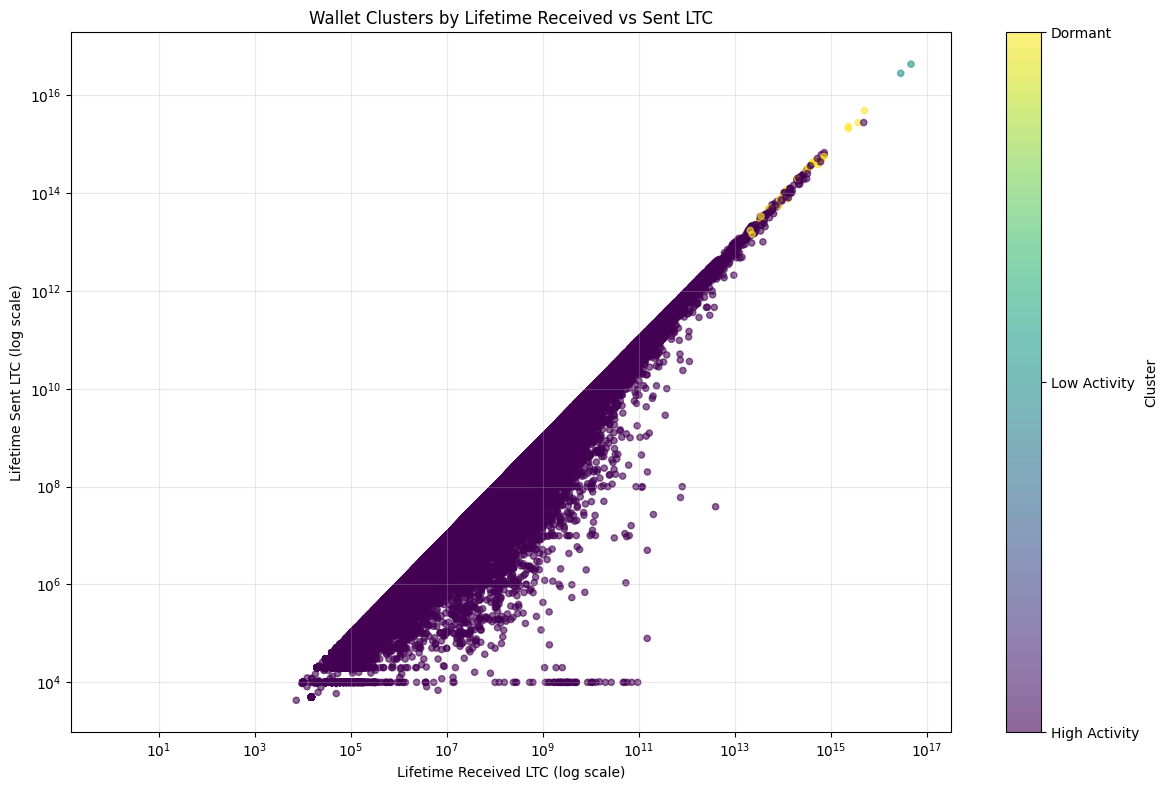


=== CLUSTER STATISTICS ===
Total wallets analyzed: 630,325

Cluster distribution:
  High Activity: 630,282 wallets (100.0%)
  Dormant: 41 wallets (0.0%)
  Low Activity: 2 wallets (0.0%)

Cluster summary statistics:
                LIFETIME_RECEIVED_LTC                              \
                                 mean        median           std   
wallet_category                                                     
Dormant                  5.406025e+14  3.068166e+14  1.012524e+15   
High Activity            3.621998e+10  2.254706e+07  6.609291e+12   
Low Activity             3.743324e+16  3.743324e+16  1.274657e+16   

                LIFETIME_SENT_LTC                              \
                             mean        median           std   
wallet_category                                                 
Dormant              4.925129e+14  3.001470e+14  9.271142e+14   
High Activity        2.713610e+10  0.000000e+00  4.181968e+12   
Low Activity         3.576880e+16  3.576880e

In [14]:
import matplotlib.pyplot as plt

# Extract data for plotting
x = df_wallet_clean['LIFETIME_RECEIVED_LTC']
y = df_wallet_clean['LIFETIME_SENT_LTC']
c = df_wallet_clean['cluster']

plt.figure(figsize=(12, 8))
scatter = plt.scatter(x, y, c=c, cmap='viridis', alpha=0.6, s=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Lifetime Received LTC (log scale)")
plt.ylabel("Lifetime Sent LTC (log scale)")
plt.title("Wallet Clusters by Lifetime Received vs Sent LTC")

# Add colorbar with cluster labels
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['High Activity', 'Low Activity', 'Dormant'])

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display cluster statistics
print("\n=== CLUSTER STATISTICS ===")
print(f"Total wallets analyzed: {len(df_wallet_clean):,}")
print("\nCluster distribution:")
cluster_counts = df_wallet_clean['wallet_category'].value_counts()
for category, count in cluster_counts.items():
    percentage = (count / len(df_wallet_clean)) * 100
    print(f"  {category}: {count:,} wallets ({percentage:.1f}%)")

print("\nCluster summary statistics:")
print(df_wallet_clean.groupby('wallet_category')[['LIFETIME_RECEIVED_LTC', 'LIFETIME_SENT_LTC', 'CURRENT_BALANCE_LTC', 'ACTIVE_DAYS']].agg(['mean', 'median', 'std']).round(2))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prepare the data for classification
X_classification = df_wallet_clean[features].copy()
y_classification = df_wallet_clean['cluster'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_classification, y_classification, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_classification
)

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print("=== MODEL PERFORMANCE ===")
print(f"Training Accuracy: {rf_classifier.score(X_train_scaled, y_train):.4f}")
print(f"Testing Accuracy: {rf_classifier.score(X_test_scaled, y_test):.4f}")

print("\n=== CLASSIFICATION REPORT ===")
# Get unique classes present in test data and create corresponding target names
unique_classes = sorted(list(set(y_test.unique()) | set(y_pred)))
target_names_filtered = [cluster_map[i] for i in unique_classes]
print(classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names_filtered))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['High Activity', 'Low Activity', 'Dormant'],
            yticklabels=['High Activity', 'Low Activity', 'Dormant'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()